## Motivation

In this notebook, we expand the previous experiment on the idea declared in section 1.5.5 (see the notebook `action-mnist-mnistc-base.ipynb`), by using convolutional neural network instead of multi-layer perceptron. The code are the same as the previous experiment except for model structure and optimizer.

We follow the [MNIST-C paper](https://arxiv.org/pdf/1906.02337.pdf), re-constructed the `Conv1` model (see their PyTorch code [on GitHub](https://github.com/pytorch/examples/blob/main/mnist/main.py)).

In [ ]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from tqdm import tqdm

!wget https://raw.githubusercontent.com/shuiruge/maxent/master/actions/utils.py
from utils import GradientRelativeEntropy

tf.random.set_seed(42)

--2024-08-19 09:43:31--  https://raw.githubusercontent.com/shuiruge/maxent/master/actions/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4677 (4.6K) [text/plain]
Saving to: ‘utils.py’

utils.py            100%[===================>]   4.57K  --.-KB/s    in 0s      

2024-08-19 09:43:31 (57.0 MB/s) - ‘utils.py’ saved [4677/4677]



## The MNIST Dataset

We follow [their code](https://github.com/pytorch/examples/blob/main/mnist/main.py#L119) for data preprocessing. The strange rescaling by `0.1307` and `0.3081` can greatly speed up the training and obtain significantly better results.

In [ ]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

def preprocess(x):
    x = x.astype('float32').reshape([-1, 28, 28, 1])
    x = x / 255.0
    x = (x - 0.1307) / 0.3081
    return x

x_train = preprocess(x_train)
x_test = preprocess(x_test)
y_train = y_train.astype('float32')
y_test = y_test.astype('float32')

## Train a CNN Model with the "Gradient Loss"

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, 3),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Conv2D(64, 3),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPool2D((2, 2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, 'relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10),
])

gradient_loss_fn = GradientRelativeEntropy(model)

In [ ]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1., decay_steps=10000, decay_rate=0.7, staircase=True)
optimizer = tf.optimizers.Adadelta(lr_schedule)

@tf.function
def train_step(x, y):
    with tf.GradientTape() as tape:
        gradient_loss = gradient_loss_fn(x, y)
        loss = tf.reduce_mean(gradient_loss.loss)
    grads = tape.gradient(loss, model.variables)
    optimizer.apply_gradients(zip(grads, model.variables))
    return loss

In [ ]:
def evaluate(model):
    return accuracy_score(y_test, tf.argmax(model(x_test), axis=1))

In [ ]:
ds = tf.data.Dataset.from_tensor_slices(
    (x_train, tf.one_hot(y_train, 10))
)
ds = ds.batch(64)

In [ ]:
for epoch in range(50):
    for x, y in tqdm(ds):
        loss = train_step(x, y)
    print(f'epoch: {epoch}, loss: {loss.numpy():.4f}, val_accuracy: {evaluate(model):.4f}')

  0%|          | 0/938 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:664: UserWarning: Gradients do not exist for variables ['seed_generator_state', 'seed_generator_state'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(
100%|██████████| 938/938 [00:23<00:00, 40.35it/s] 


epoch: 0, loss: 0.1093, val_accuracy: 0.9843


100%|██████████| 938/938 [00:06<00:00, 151.98it/s]


epoch: 1, loss: 0.0997, val_accuracy: 0.9881


100%|██████████| 938/938 [00:06<00:00, 153.53it/s]


epoch: 2, loss: 0.0992, val_accuracy: 0.9898


100%|██████████| 938/938 [00:05<00:00, 160.80it/s]


epoch: 3, loss: 0.0957, val_accuracy: 0.9901


100%|██████████| 938/938 [00:05<00:00, 158.01it/s]


epoch: 4, loss: 0.0974, val_accuracy: 0.9908


100%|██████████| 938/938 [00:05<00:00, 161.27it/s]


epoch: 5, loss: 0.0963, val_accuracy: 0.9908


100%|██████████| 938/938 [00:05<00:00, 157.28it/s]


epoch: 6, loss: 0.0953, val_accuracy: 0.9908


100%|██████████| 938/938 [00:05<00:00, 160.50it/s]


epoch: 7, loss: 0.0951, val_accuracy: 0.9913


100%|██████████| 938/938 [00:05<00:00, 156.78it/s]


epoch: 8, loss: 0.0946, val_accuracy: 0.9914


100%|██████████| 938/938 [00:05<00:00, 160.24it/s]


epoch: 9, loss: 0.0948, val_accuracy: 0.9918


100%|██████████| 938/938 [00:06<00:00, 156.18it/s]


epoch: 10, loss: 0.0939, val_accuracy: 0.9918


100%|██████████| 938/938 [00:05<00:00, 159.25it/s]


epoch: 11, loss: 0.0937, val_accuracy: 0.9921


100%|██████████| 938/938 [00:06<00:00, 155.16it/s]


epoch: 12, loss: 0.0938, val_accuracy: 0.9921


100%|██████████| 938/938 [00:06<00:00, 153.94it/s]


epoch: 13, loss: 0.0937, val_accuracy: 0.9921


100%|██████████| 938/938 [00:06<00:00, 155.32it/s]


epoch: 14, loss: 0.0937, val_accuracy: 0.9922


100%|██████████| 938/938 [00:05<00:00, 159.26it/s]


epoch: 15, loss: 0.0937, val_accuracy: 0.9924


100%|██████████| 938/938 [00:06<00:00, 155.57it/s]


epoch: 16, loss: 0.0936, val_accuracy: 0.9922


100%|██████████| 938/938 [00:06<00:00, 149.78it/s]


epoch: 17, loss: 0.0936, val_accuracy: 0.9924


100%|██████████| 938/938 [00:06<00:00, 156.09it/s]


epoch: 18, loss: 0.0935, val_accuracy: 0.9924


100%|██████████| 938/938 [00:05<00:00, 159.65it/s]


epoch: 19, loss: 0.0936, val_accuracy: 0.9924


100%|██████████| 938/938 [00:06<00:00, 156.03it/s]


epoch: 20, loss: 0.0935, val_accuracy: 0.9924


100%|██████████| 938/938 [00:05<00:00, 159.42it/s]


epoch: 21, loss: 0.0931, val_accuracy: 0.9924


100%|██████████| 938/938 [00:06<00:00, 155.25it/s]


epoch: 22, loss: 0.0931, val_accuracy: 0.9926


100%|██████████| 938/938 [00:05<00:00, 157.93it/s]


epoch: 23, loss: 0.0932, val_accuracy: 0.9925


100%|██████████| 938/938 [00:06<00:00, 155.39it/s]


epoch: 24, loss: 0.0931, val_accuracy: 0.9927


100%|██████████| 938/938 [00:05<00:00, 158.74it/s]


epoch: 25, loss: 0.0931, val_accuracy: 0.9925


100%|██████████| 938/938 [00:06<00:00, 155.66it/s]


epoch: 26, loss: 0.0930, val_accuracy: 0.9925


100%|██████████| 938/938 [00:05<00:00, 158.85it/s]


epoch: 27, loss: 0.0931, val_accuracy: 0.9925


100%|██████████| 938/938 [00:06<00:00, 155.05it/s]


epoch: 28, loss: 0.0930, val_accuracy: 0.9925


100%|██████████| 938/938 [00:05<00:00, 158.75it/s]


epoch: 29, loss: 0.0931, val_accuracy: 0.9925


100%|██████████| 938/938 [00:06<00:00, 154.90it/s]


epoch: 30, loss: 0.0930, val_accuracy: 0.9925


100%|██████████| 938/938 [00:05<00:00, 158.53it/s]


epoch: 31, loss: 0.0930, val_accuracy: 0.9926


100%|██████████| 938/938 [00:06<00:00, 156.17it/s]


epoch: 32, loss: 0.0930, val_accuracy: 0.9926


100%|██████████| 938/938 [00:05<00:00, 158.90it/s]


epoch: 33, loss: 0.0929, val_accuracy: 0.9926


100%|██████████| 938/938 [00:06<00:00, 155.55it/s]


epoch: 34, loss: 0.0929, val_accuracy: 0.9926


100%|██████████| 938/938 [00:05<00:00, 158.31it/s]


epoch: 35, loss: 0.0930, val_accuracy: 0.9926


100%|██████████| 938/938 [00:06<00:00, 155.20it/s]


epoch: 36, loss: 0.0929, val_accuracy: 0.9925


100%|██████████| 938/938 [00:05<00:00, 158.98it/s]


epoch: 37, loss: 0.0929, val_accuracy: 0.9926


100%|██████████| 938/938 [00:05<00:00, 156.42it/s]


epoch: 38, loss: 0.0929, val_accuracy: 0.9926


100%|██████████| 938/938 [00:05<00:00, 158.85it/s]


epoch: 39, loss: 0.0928, val_accuracy: 0.9926


100%|██████████| 938/938 [00:06<00:00, 155.81it/s]


epoch: 40, loss: 0.0928, val_accuracy: 0.9927


100%|██████████| 938/938 [00:05<00:00, 156.66it/s]


epoch: 41, loss: 0.0928, val_accuracy: 0.9927


100%|██████████| 938/938 [00:05<00:00, 156.72it/s]


epoch: 42, loss: 0.0929, val_accuracy: 0.9925


100%|██████████| 938/938 [00:05<00:00, 157.71it/s]


epoch: 43, loss: 0.0928, val_accuracy: 0.9927


100%|██████████| 938/938 [00:10<00:00, 91.76it/s] 


epoch: 44, loss: 0.0928, val_accuracy: 0.9925


100%|██████████| 938/938 [00:05<00:00, 158.71it/s]


epoch: 45, loss: 0.0928, val_accuracy: 0.9926


100%|██████████| 938/938 [00:06<00:00, 154.91it/s]


epoch: 46, loss: 0.0928, val_accuracy: 0.9926


100%|██████████| 938/938 [00:05<00:00, 158.65it/s]


epoch: 47, loss: 0.0928, val_accuracy: 0.9926


100%|██████████| 938/938 [00:06<00:00, 155.49it/s]


epoch: 48, loss: 0.0928, val_accuracy: 0.9926


100%|██████████| 938/938 [00:05<00:00, 158.96it/s]


epoch: 49, loss: 0.0928, val_accuracy: 0.9927


In [ ]:
evaluate(model)

0.9927

## Baseline Model with the Usual Loss

For comparing, we use the same architecture for baseline model.

In [ ]:
baseline_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, 3),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Conv2D(64, 3),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPool2D((2, 2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, 'relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10),
])

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1., decay_steps=10000, decay_rate=0.7, staircase=True)
baseline_model.compile(
    optimizer=tf.optimizers.Adadelta(lr_schedule),
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [ ]:
baseline_model.fit(
    x_train, y_train,
    batch_size=64,
    epochs=14,
    validation_data=(x_test, y_test),
    verbose=2,
)

Epoch 1/14
938/938 - 9s - 10ms/step - accuracy: 0.9426 - loss: 0.1909 - val_accuracy: 0.9831 - val_loss: 0.0537
Epoch 2/14
938/938 - 4s - 4ms/step - accuracy: 0.9784 - loss: 0.0727 - val_accuracy: 0.9841 - val_loss: 0.0463
Epoch 3/14
938/938 - 4s - 4ms/step - accuracy: 0.9833 - loss: 0.0567 - val_accuracy: 0.9871 - val_loss: 0.0387
Epoch 4/14
938/938 - 4s - 4ms/step - accuracy: 0.9860 - loss: 0.0477 - val_accuracy: 0.9887 - val_loss: 0.0338
Epoch 5/14
938/938 - 6s - 6ms/step - accuracy: 0.9883 - loss: 0.0413 - val_accuracy: 0.9886 - val_loss: 0.0323
Epoch 6/14
938/938 - 5s - 5ms/step - accuracy: 0.9888 - loss: 0.0375 - val_accuracy: 0.9894 - val_loss: 0.0318
Epoch 7/14
938/938 - 4s - 4ms/step - accuracy: 0.9900 - loss: 0.0362 - val_accuracy: 0.9894 - val_loss: 0.0313
Epoch 8/14
938/938 - 4s - 5ms/step - accuracy: 0.9906 - loss: 0.0322 - val_accuracy: 0.9914 - val_loss: 0.0322
Epoch 9/14
938/938 - 4s - 5ms/step - accuracy: 0.9907 - loss: 0.0327 - val_accuracy: 0.9910 - val_loss: 0.0299


In [ ]:
evaluate(baseline_model)

0.9901

## Model Robustness

Now, we compare the robustness of the model and the baseline. To do so, we add Gaussian and uniform noises to the test data and check the accuracy. (Because of the rescaling of input data, we shall not clip the input value as before.)

In [ ]:
stddevs, model_accs, baseline_accs = [], [], []
for stddev in tqdm(np.linspace(0, 0.5, 50)):
    stddevs.append(stddev)
    x_test_noised = x_test + tf.random.normal(tf.shape(x_test)) * stddev
    # x_test_noised = x_test + tf.random.uniform(tf.shape(x_test), -1., 1.) * stddev
    model_accs.append(
        accuracy_score(y_test, tf.argmax(model(x_test_noised), axis=1))
    )
    baseline_accs.append(
        accuracy_score(y_test, tf.argmax(baseline_model(x_test_noised), axis=1))
    )

100%|██████████| 50/50 [00:16<00:00,  3.07it/s]


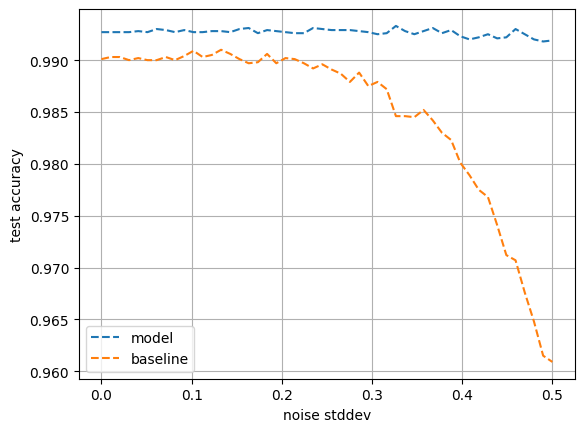

In [ ]:
plt.plot(stddevs, model_accs, '--', label='model')
plt.plot(stddevs, baseline_accs, '--', label='baseline')
plt.xlabel('noise stddev')
plt.ylabel('test accuracy')
plt.legend()
plt.grid()
plt.show()

## MNIST-C

In this section, we are to exame the model and the baseline model on the [MNIST-C](https://github.com/google-research/mnist-c) dataset, which was designed for evaluating the robustness of models trained on MNIST dataset.

We have downloaded the ZIP file from [here](https://zenodo.org/records/3239543), and unpacked into the current folder.

In [ ]:
# !unzip -x mnist_c.zip -d ./

Or, load MNIST-C dataset from drive, where I have uploaded the ZIP file. This will greatly speed up the progress.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!unzip /content/drive/MyDrive/mnist_c.zip -d ./

Mounted at /content/drive
Archive:  /content/drive/MyDrive/mnist_c.zip
   creating: ./mnist_c/
   creating: ./mnist_c/impulse_noise/
  inflating: ./mnist_c/impulse_noise/test_images.npy  
  inflating: ./mnist_c/impulse_noise/train_images.npy  
  inflating: ./mnist_c/impulse_noise/test_labels.npy  
  inflating: ./mnist_c/impulse_noise/train_labels.npy  
   creating: ./mnist_c/canny_edges/
  inflating: ./mnist_c/canny_edges/test_images.npy  
  inflating: ./mnist_c/canny_edges/train_images.npy  
  inflating: ./mnist_c/canny_edges/test_labels.npy  
  inflating: ./mnist_c/canny_edges/train_labels.npy  
   creating: ./mnist_c/zigzag/
  inflating: ./mnist_c/zigzag/test_images.npy  
  inflating: ./mnist_c/zigzag/train_images.npy  
  inflating: ./mnist_c/zigzag/test_labels.npy  
  inflating: ./mnist_c/zigzag/train_labels.npy  
   creating: ./mnist_c/dotted_line/
  inflating: ./mnist_c/dotted_line/test_images.npy  
  inflating: ./mnist_c/dotted_line/train_images.npy  
  inflating: ./mnist_c/dott

In [ ]:
print('noise type -- model accuracy -- baseline accuracy -- out perform')
for noise_type in os.listdir('mnist_c'):
    x_eval = np.load(f'mnist_c/{noise_type}/test_images.npy')
    y_eval = np.load(f'mnist_c/{noise_type}/test_labels.npy')

    x_eval = preprocess(x_eval)
    y_eval = y_eval.astype('float32')

    model_eval = accuracy_score(y_eval, tf.argmax(model(x_eval), axis=1))
    baseline_eval = accuracy_score(y_eval, tf.argmax(baseline_model(x_eval), axis=1))
    out_perform = model_eval - baseline_eval

    print(f'{noise_type} -- {model_eval} -- {baseline_eval} -- {out_perform*100:.1f}%')

noise type -- model accuracy -- baseline accuracy -- out perform
shot_noise -- 0.9839 -- 0.9434 -- 4.0%
translate -- 0.611 -- 0.5305 -- 8.1%
scale -- 0.9567 -- 0.9499 -- 0.7%
fog -- 0.3166 -- 0.6505 -- -33.4%
glass_blur -- 0.9213 -- 0.8405 -- 8.1%
dotted_line -- 0.9824 -- 0.9594 -- 2.3%
impulse_noise -- 0.8729 -- 0.589 -- 28.4%
identity -- 0.9927 -- 0.9901 -- 0.3%
spatter -- 0.9852 -- 0.9802 -- 0.5%
brightness -- 0.3483 -- 0.7058 -- -35.8%
canny_edges -- 0.7815 -- 0.7373 -- 4.4%
rotate -- 0.941 -- 0.9153 -- 2.6%
zigzag -- 0.8715 -- 0.8526 -- 1.9%
shear -- 0.9825 -- 0.9778 -- 0.5%
motion_blur -- 0.9602 -- 0.8886 -- 7.2%
stripe -- 0.92 -- 0.9666 -- -4.7%


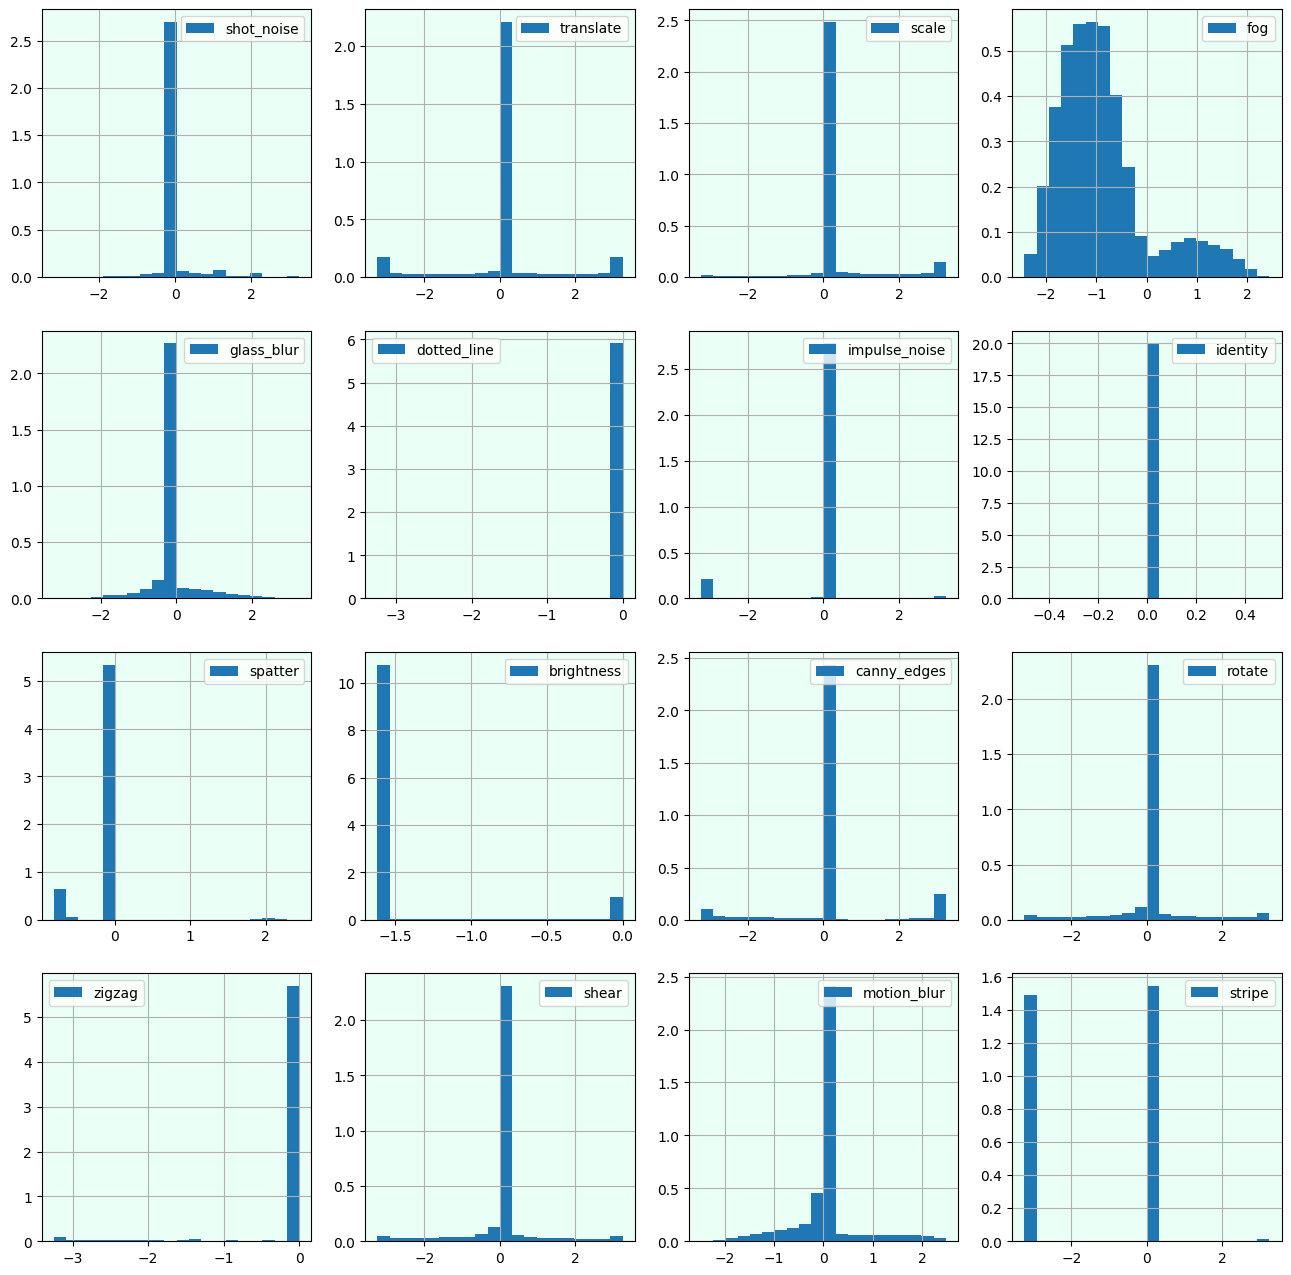

In [ ]:
fig, axs = plt.subplots(4, 4, figsize=(16, 16))
for i, noise_type in enumerate(os.listdir('mnist_c')):
    j = i // 4
    k = i % 4
    ax = axs[j][k]

    x_eval = np.load(f'mnist_c/{noise_type}/test_images.npy')
    x_eval = preprocess(x_eval)

    diff = (x_test - x_eval).reshape([-1])
    ax.hist(diff, 20, label=noise_type, density=True)
    ax.legend()
    ax.grid()
    ax.set_facecolor('#eafff5')

plt.show()

## Conclusion

We follow the MNIST-C paper, constructed a Conv1 neural network, used an optimizer with scheduled learning-rate and a strange input preprocess. Model was trained by minimizing the "gradient loss". We also trained a baseline model with the same architecture, by minimizing the loss as usual.

- We cannot reproduce the figure 3 in the paper.
- Again, for Gaussian and uniform noises, the robustness is greatly out-performs the baseline.
- Examed on the MNIST-C dataset, robustness out-performs the baseline for most of the noise types. And for some noise types, it is significiant.